In [4]:
from Bio.Seq import Seq
from Bio.SeqUtils import MeltingTemp as mt
from itertools import product, islice
import re
from concurrent.futures import ProcessPoolExecutor, as_completed
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from nupack import *
import random
# Define the model
model1 = Model(material='dna', ensemble='stacking', celsius=20, sodium=1, magnesium=0.00)

In [5]:
class ComplexNotFound(Exception):
    """Exception when a complex is not found."""
    pass

def get_complex_concentration(complexes, s1_index, s2_index):
    """Retrieve concentration, trying both orderings."""
    complex_name_1 = f's{s1_index}+s{s2_index}'
    complex_name_2 = f's{s2_index}+s{s1_index}'
    
    for complex_key, concentration in complexes.items():
        if complex_key.name in [f'({complex_name_1})', f'({complex_name_2})']:
            return concentration, complex_key.name.strip('()')
    
    raise ComplexNotFound(f"Complex '{complex_name_1}' or '{complex_name_2}' not found.")

#swappng pairs to get the best
def find_best_swaps(input_file_path, stock_file_path, strand_pairs, output_file_path=None):
    """Find the best swaps for multiple specified strand pairs and write the resulting sequence to a new file if output_file_path is provided."""
    
    # Read the sequences from the input file
    with open(input_file_path, 'r') as file:
        sequences = [line.strip() for line in file.readlines() if line.strip()]

    # Read stock file to get pairs for swapping
    with open(stock_file_path, 'r') as stock_file:
        stock_pairs = [line.strip() for line in stock_file if line.strip()]

    # Track the maximum concentration for each strand pair
    best_swaps = []
    
    # Calculate the total number of swaps to process across all strand pairs
    total_swaps = len(stock_pairs) // 2 * len(strand_pairs)  # Total number of swaps for all strand pairs

    # Create a single tqdm progress bar for all swaps
    with tqdm(total=total_swaps, desc="Processing swaps", leave=True) as progress_bar:
        # Loop over each strand pair (multiple pairs)
        for strand1_index, strand2_index in strand_pairs:
            # Store the original sequences for the specified strands
            original_s1 = sequences[strand1_index - 1]  # Adjust for zero-indexing
            original_s2 = sequences[strand2_index - 1]  # Adjust for zero-indexing

            # Track the maximum concentration for the specified strands
            max_concentration = 0
            best_swap = None

            # Loop over stock file to swap specified strands and calculate concentration
            i = 0  # Track the index in stock_pairs
            while i < len(stock_pairs) - 1:  # Ensure we don't exceed bounds
                try:
                    # Ensure we have a valid pair from the stock file
                    s1_new = stock_pairs[i]
                    s2_new = stock_pairs[i + 1]
                except IndexError:
                    continue

                # Temporarily update the sequences at the specified strand indices
                sequences[strand1_index - 1], sequences[strand2_index - 1] = s1_new, s2_new

                # Prefix each sequence with 12-thymidine (12T)
                strands_temp = [Strand('TTTTTTTTTTTT' + seq, name=f's{i+1}') for i, seq in enumerate(sequences)]

                # Create a new tube for the updated sequences
                tube_temp = Tube({strand: 10e-9 for strand in strands_temp}, SetSpec(max_size=2), name='swap_test')

                # Perform complex analysis and concentration calculations for the swapped strands
                result_temp = complex_analysis(complexes=tube_temp.complexes, model=model1, compute=['pfunc'])
                conc_results_temp = complex_concentrations(tube=tube_temp, data=result_temp)
                tube_result_temp = conc_results_temp.tubes[tube_temp]

                try:
                    # Get the concentration for the swapped pair
                    concentration, _ = get_complex_concentration(tube_result_temp.complex_concentrations, strand1_index, strand2_index)
                    concentration *= 1e9  # Convert to nM

                    # Check if this swap gives the highest concentration
                    if concentration > max_concentration:
                        max_concentration = concentration
                        best_swap = (s1_new, s2_new, concentration)

                        # Once a valid swap is found, remove this pair from the stock temporarily (without modifying stock.txt)
                        stock_pairs.pop(i)     # Remove s1_new
                        stock_pairs.pop(i)     # Remove s2_new (Note: After popping s1_new, the index stays the same for s2_new)
                        continue  # Go back to check the next pair after removal

                except ComplexNotFound:
                    pass

                # Move to the next pair
                i += 2

                # Update the total progress bar
                progress_bar.update(1)

            # If a best swap was found, keep it for the next comparisons
            if best_swap:
                sequences[strand1_index - 1], sequences[strand2_index - 1] = best_swap[0], best_swap[1]  # Apply best swap dynamically
                best_swaps.append(f"\nBest swap for s{strand1_index}+s{strand2_index} ({original_s1} + {original_s2}) is {best_swap[0]} + {best_swap[1]} with {best_swap[2]:.2f} nM")
            else:
                best_swaps.append(f"No valid swaps found for s{strand1_index}+{strand2_index}.")

    # Print all the results after the progress is complete
    for swap in best_swaps:
        print(swap)

    # If an output file path is provided, write the final swapped sequences to a file
    if output_file_path:
        with open(output_file_path, 'w') as output_file:
            for seq in sequences:
                output_file.write(seq + '\n')

        print(f"Swapped sequences written to {output_file_path}")

# swap TOEHOLD
def find_best_toehold_swaps(stock_file_path, toehold="TAG", output_file_path=None):
    """
    Find the best swaps for each pair by adding a 3-nucleotide toehold to the end of the first sequence
    in each pair and comparing their concentrations.

    Args:
    - stock_file_path: The path to the stock file containing sequence pairs.
    - toehold: The 3-nucleotide toehold to be added to the end of the first sequence.
    - output_file_path: Optional file to write the final sequences with the best swap.
    """

    # Read stock file to get pairs for swapping
    with open(stock_file_path, 'r') as stock_file:
        stock_pairs = [line.strip() for line in stock_file if line.strip()]

    # Track the highest concentration and the best pair
    max_concentration = 0
    best_swap = None

    # Create a progress bar for all swaps
    with tqdm(total=len(stock_pairs) // 2, desc="Processing toehold swaps", leave=True) as progress_bar:
        # Loop over each pair in stock
        for i in range(0, len(stock_pairs), 2):
            try:
                # Ensure we have a valid pair from the stock file
                seq1_original = stock_pairs[i]
                seq2 = stock_pairs[i + 1]

                # Add the toehold to the end of the first sequence
                seq1_with_toehold = seq1_original + toehold

                # Prefix each sequence with 12-thymidine (12T)
                strands_temp = [
                    Strand('TTTTTTTTTTTT' + seq1_with_toehold, name=f's{i+1}'),
                    Strand('TTTTTTTTTTTT' + seq2, name=f's{i+2}')
                ]

                # Create a new tube for the updated sequences
                tube_temp = Tube({strand: 10e-9 for strand in strands_temp}, SetSpec(max_size=2), name='toehold_test')

                # Perform complex analysis and concentration calculations for the modified sequences
                result_temp = complex_analysis(complexes=tube_temp.complexes, model=model1, compute=['pfunc'])
                conc_results_temp = complex_concentrations(tube=tube_temp, data=result_temp)
                tube_result_temp = conc_results_temp.tubes[tube_temp]

                try:
                    # Get the concentration for the modified pair
                    concentration, _ = get_complex_concentration(tube_result_temp.complex_concentrations, i + 1, i + 2)
                    concentration *= 1e9  # Convert to nM

                    # Check if this pair gives the highest concentration
                    if concentration > max_concentration:
                        max_concentration = concentration
                        best_swap = (seq1_original, seq2, seq1_with_toehold, concentration)

                except ComplexNotFound:
                    pass

                # Update the progress bar
                progress_bar.update(1)

            except IndexError:
                continue  # Ignore incomplete pairs

    # Print the result with the highest concentration
    if best_swap:
        print(f"\nBest swap for ({best_swap[0]} + {best_swap[1]}) with Toehold ('{toehold}') is {best_swap[2]} + {best_swap[1]} with {best_swap[3]:.2f} nM")
    else:
        print("No valid swaps found.")

    # Optionally write the best swap to an output file
    if output_file_path and best_swap:
        with open(output_file_path, 'w') as output_file:
            output_file.write(f"Original: {best_swap[0]} + {best_swap[1]}\n")
            output_file.write(f"Toehold: {best_swap[2]} + {best_swap[1]}\n")
            output_file.write(f"Concentration: {best_swap[3]:.2f} nM\n")

        print(f"Best toehold swap written to {output_file_path}")


In [76]:
# Read the sequences from the file
with open('stock.txt', 'r') as file:
    # Read lines 1 to 274, stripping whitespace and skipping empty lines
    sequences = [line.strip() for line in file.readlines()[:] if line.strip()]

# Remove the first 12 characters from each sequence
trimmed_sequences = [seq[12:] for seq in sequences]

# Save the trimmed sequences to a new file
with open('seqs_no_12T.txt', 'w') as file:
    for seq in trimmed_sequences:
        file.write(seq + '\n')

Generated Complex Names: ['s27+s28', 's5+s6', 's17+s18', 's33+s34', 's7+s8', 's29+s30', 's31+s32', 's3+s4', 's1+s2', 's19+s20', 's13+s14', 's9+s10', 's11+s12', 's15+s16', 's25+s26', 's21+s22', 's23+s24']
s27+s28 (ATACCAACGAAG + CGTTGGTAT) is 9.85 nM
s5+s6 (ATACAGCACAGA + GTGCTGTAT) is 9.81 nM
s17+s18 (ATATGAGCGAGTTC + CGCTCATAT) is 9.78 nM
s33+s34 (ATAACCACGATC + CGTGGTTAT) is 9.73 nM
s7+s8 (ACGAGGAATATG + ATTCCTCGT) is 9.63 nM
s29+s30 (ATGACACCTACT + AGGTGTCAT) is 9.57 nM
s31+s32 (ATATTGCCGGTA + CGGCAATAT) is 9.50 nM
s3+s4 (ATCATACGCTAG + GCGTATGAT) is 9.49 nM
s1+s2 (ATTCACTGCCAA + GCAGTGAAT) is 9.48 nM
s19+s20 (ACCAGACAT + ATGTCTGGT) is 9.44 nM
s13+s14 (TATGCCACT + AGTGGCATA) is 9.38 nM
s9+s10 (ATGGACAGT + ACTGTCCAT) is 9.38 nM
s11+s12 (ATGACCTGT + ACAGGTCAT) is 9.34 nM
s15+s16 (AGAGACGAT + ATCGTCTCT) is 9.34 nM
s25+s26 (GCACGATAT + ATATCGTGC) is 9.32 nM
s21+s22 (AGCAGAGAT + ATCTCTGCT) is 9.30 nM
s23+s24 (ATACGGCTA + TAGCCGTAT) is 9.28 nM

Forward Sequences:
ATTCACTGCCAA
ATCATACGCTAG

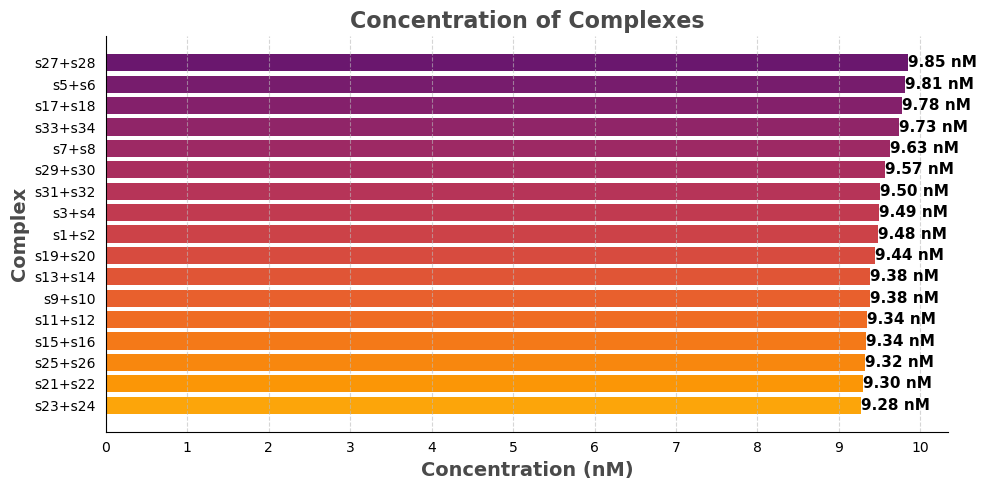

In [6]:
# Define the input file path
input_file_path = 'v2_20pairs_TH.txt'

# Read the sequences from the input file and store lines 1 to 274
with open(input_file_path, 'r') as file:
    sequences = [line.strip() for line in file.readlines()[:] if line.strip()]

# Prefix each sequence with 12-thymidine (12T) 
strands = [Strand('TTTTTTTTTTTT' + seq, name=f's{i+1}') for i, seq in enumerate(sequences)]

# # no Ts
# strands = [Strand(seq, name=f's{i+1}') for i, seq in enumerate(sequences)]

tube_all = Tube({strand: 10e-9 for strand in strands}, SetSpec(max_size=2), name='all_in_one')

# Perform complex analysis and concentration calculations
result_all = complex_analysis(complexes=tube_all.complexes, model=model1, compute=['pfunc'])
conc_results_all = complex_concentrations(tube=tube_all, data=result_all)
tube_result_all = conc_results_all.tubes[tube_all]

# Retrieve and organize concentration data for printing
complex_concentration_pairs_with_info = []
for i in range(0, len(sequences), 2):
    concentration, used_complex_name = get_complex_concentration(tube_result_all.complex_concentrations, i + 1, i + 2)
    concentration *= 1e9  # Convert to nM
    seq1, seq2 = sequences[i], sequences[i+1]
    complex_name = f's{i+1}+s{i+2}'
    complex_concentration_pairs_with_info.append((complex_name, f'{seq1} + {seq2}', concentration))

# Sort by concentration
sorted_concentrations = sorted(complex_concentration_pairs_with_info, key=lambda x: x[2], reverse=True)

# Print complex names and concentrations
print("Generated Complex Names:", [name for name, _, _ in sorted_concentrations])
for complex_id, names, concentration in sorted_concentrations:
    print(f"{complex_id} ({names}) is {concentration:.2f} nM")

# Print forward and reverse sequences
print("\nForward Sequences:")
for seq in sequences[::2]:
    print(seq)

print("\nReverse Sequences:")
for seq in sequences[1::2]:
    print(seq)

# # Print all sequences sorted by concentration
# print("\nSequence Pairs From High to Low Concentration")
# all_sequences_sorted = [seq for _, names, _ in sorted_concentrations for seq in names.split(' + ')]
# for seq in all_sequences_sorted:
#     print(seq)

# # Print forward and reverse sequences
# print("\nForward Sequences:")
# for seq in all_sequences_sorted[::2]:
#     print(seq)

# print("\nReverse Sequences:")
# for seq in all_sequences_sorted[1::2]:
#     print(seq)

plt.figure(figsize=(10, 5))
n = len(sorted_concentrations)
colors = plt.cm.inferno(np.linspace(0.3, 0.8, n))
bars = plt.barh([complex_id for complex_id, _, _ in sorted_concentrations],
                [concentration for _, _, concentration in sorted_concentrations],
                color=colors)

plt.xlabel('Concentration (nM)', fontsize=14, fontweight='bold', color='#4A4A4A')
plt.ylabel('Complex', fontsize=14, fontweight='bold', color='#4A4A4A')
plt.title('Concentration of Complexes', fontsize=16, fontweight='bold', color='#4A4A4A')

plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6, color='#BBBBBB')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True, color='#4A4A4A')
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=True, color='#4A4A4A')

# Setting x-axis ticks to display whole numbers
max_concentration = max([concentration for _, _, concentration in sorted_concentrations])
plt.xticks(np.arange(0, max_concentration + 1, 1))  # Adjust step to 1 to include every integer

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f} nM', va='center', ha='left',
             color='black', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('v2_dancers', dpi=300)
plt.show()


In [10]:
# Define input and stock file paths
input_file_path = 'v2_20pairs_TH_test.txt'   # The file containing the original sequences
stock_file_path = 'stock.txt'                # The file containing the stock pairs

# Specify the strand pairs you want to swap (multiple pairs)
strand_pairs = [(25,26)]

# Call the function to find the best swaps for the strand pairs
find_best_swaps(input_file_path, stock_file_path, strand_pairs, output_file_path='swapped.txt')



Processing swaps:  88%|████████▊ | 49/56 [00:30<00:04,  1.62it/s]


Best swap for s25+s26 (ACTGTCCAT + ACAGGTCAT) is GACGCATAT + ATATGCGTC with 9.23 nM
Swapped sequences written to swapped.txt


In [57]:
# find best TOEHOLD match
find_best_toehold_swaps('stock.txt', toehold="AGTTC")

Processing toehold swaps: 100%|██████████| 49/49 [00:00<00:00, 240.89it/s]


Best swap for (ATATGAGCG + CGCTCATAT) with Toehold ('AGTTC') is ATATGAGCGAGTTC + CGCTCATAT with 9.78 nM


Generated Complex Names: ['s27+s28', 's5+s6', 's17+s18', 's33+s34', 's7+s8', 's29+s30', 's31+s32', 's3+s4', 's1+s2', 's19+s20', 's13+s14', 's9+s10', 's11+s12', 's15+s16', 's25+s26', 's21+s22', 's23+s24']
s27+s28 (ATACCAACGAAG + CGTTGGTAT) is 9.85 nM
s5+s6 (ATACAGCACAGA + GTGCTGTAT) is 9.81 nM
s17+s18 (ATATGAGCGAGTTC + CGCTCATAT) is 9.78 nM
s33+s34 (ATAACCACGATC + CGTGGTTAT) is 9.73 nM
s7+s8 (ACGAGGAATATG + ATTCCTCGT) is 9.63 nM
s29+s30 (ATGACACCTACT + AGGTGTCAT) is 9.57 nM
s31+s32 (ATATTGCCGGTA + CGGCAATAT) is 9.50 nM
s3+s4 (ATCATACGCTAG + GCGTATGAT) is 9.49 nM
s1+s2 (ATTCACTGCCAA + GCAGTGAAT) is 9.48 nM
s19+s20 (ACCAGACAT + ATGTCTGGT) is 9.44 nM
s13+s14 (TATGCCACT + AGTGGCATA) is 9.38 nM
s9+s10 (ATGGACAGT + ACTGTCCAT) is 9.38 nM
s11+s12 (ATGACCTGT + ACAGGTCAT) is 9.34 nM
s15+s16 (AGAGACGAT + ATCGTCTCT) is 9.34 nM
s25+s26 (GCACGATAT + ATATCGTGC) is 9.32 nM
s21+s22 (AGCAGAGAT + ATCTCTGCT) is 9.30 nM
s23+s24 (ATACGGCTA + TAGCCGTAT) is 9.28 nM


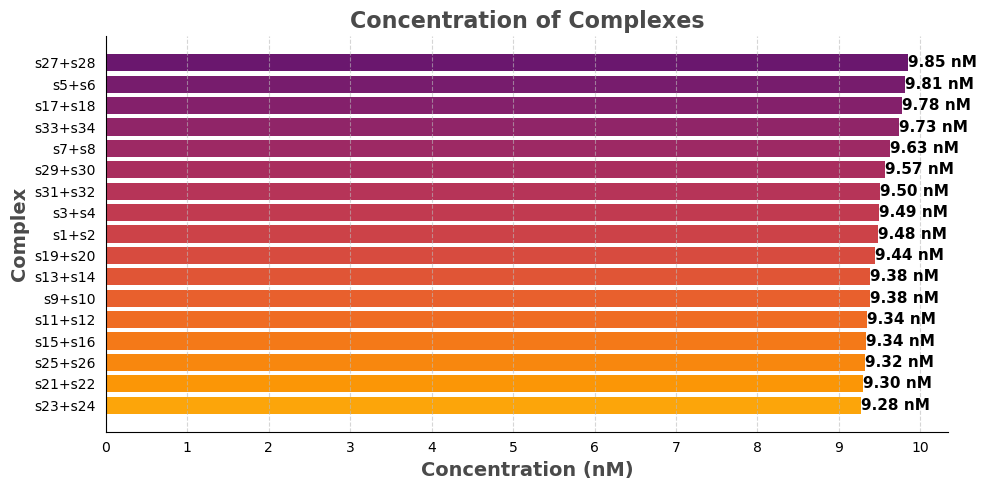

In [64]:
#  check new swapped

input_file_path = 'swapped.txt'

with open(input_file_path, 'r') as file:
    sequences = [line.strip() for line in file.readlines()[:] if line.strip()]

# Prefix each sequence with 12-thymidine (12T) 
strands = [Strand('TTTTTTTTTTTT' + seq, name=f's{i+1}') for i, seq in enumerate(sequences)]

# # no Ts
# strands = [Strand(seq, name=f's{i+1}') for i, seq in enumerate(sequences)]

tube_all = Tube({strand: 10e-9 for strand in strands}, SetSpec(max_size=2), name='all_in_one')

# Perform complex analysis and concentration calculations
result_all = complex_analysis(complexes=tube_all.complexes, model=model1, compute=['pfunc'])
conc_results_all = complex_concentrations(tube=tube_all, data=result_all)
tube_result_all = conc_results_all.tubes[tube_all]

# Retrieve and organize concentration data for printing
complex_concentration_pairs_with_info = []
for i in range(0, len(sequences), 2):
    concentration, used_complex_name = get_complex_concentration(tube_result_all.complex_concentrations, i + 1, i + 2)
    concentration *= 1e9  # Convert to nM
    seq1, seq2 = sequences[i], sequences[i+1]
    complex_name = f's{i+1}+s{i+2}'
    complex_concentration_pairs_with_info.append((complex_name, f'{seq1} + {seq2}', concentration))

# Sort by concentration
sorted_concentrations = sorted(complex_concentration_pairs_with_info, key=lambda x: x[2], reverse=True)

# Print complex names and concentrations
print("Generated Complex Names:", [name for name, _, _ in sorted_concentrations])
for complex_id, names, concentration in sorted_concentrations:
    print(f"{complex_id} ({names}) is {concentration:.2f} nM")

plt.figure(figsize=(10, 5))
n = len(sorted_concentrations)
colors = plt.cm.inferno(np.linspace(0.3, 0.8, n))
bars = plt.barh([complex_id for complex_id, _, _ in sorted_concentrations],
                [concentration for _, _, concentration in sorted_concentrations],
                color=colors)

plt.xlabel('Concentration (nM)', fontsize=14, fontweight='bold', color='#4A4A4A')
plt.ylabel('Complex', fontsize=14, fontweight='bold', color='#4A4A4A')
plt.title('Concentration of Complexes', fontsize=16, fontweight='bold', color='#4A4A4A')

plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6, color='#BBBBBB')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True, color='#4A4A4A')
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=True, color='#4A4A4A')

# Setting x-axis ticks to display whole numbers
max_concentration = max([concentration for _, _, concentration in sorted_concentrations])
plt.xticks(np.arange(0, max_concentration + 1, 1))  # Adjust step to 1 to include every integer

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f} nM', va='center', ha='left',
             color='black', fontsize=11, fontweight='bold')

plt.tight_layout()
# plt.savefig('v2_dancers', dpi=300)
plt.show()

In [65]:
# # Print all sequences sorted by concentration
# print("\nSequence Pairs From High to Low Concentration")
# all_sequences_sorted = [seq for _, names, _ in sorted_concentrations for seq in names.split(' + ')]
# for seq in all_sequences_sorted:
#     print(seq)

# # Save the sorted sequences to a text file
# output_file_path = 'seq_matt_conc_high_to_low.txt'
# with open(output_file_path, 'w') as file:
#     for seq in all_sequences_sorted:
#         file.write(seq + '\n')

In [4]:
# Print all sequences sorted by concentration
print("\nSequence Pairs From High to Low Concentration")
all_sequences_sorted = [seq for _, names, _ in sorted_concentrations for seq in names.split(' + ')]
for seq in all_sequences_sorted:
    print(seq)

# Print forward and reverse sequences
print("\nForward Sequences:")
for seq in all_sequences_sorted[::2]:
    print(seq)

print("\nReverse Sequences:")
for seq in all_sequences_sorted[1::2]:
    print(seq)


Sequence Pairs From High to Low Concentration
ATACCAACGAAG
CGTTGGTAT
ATACAGCACAGA
GTGCTGTAT
ACGAGGAATATG
ATTCCTCGT
ATGACACCTACT
AGGTGTCAT
ATATTGCCGGTA
CGGCAATAT
ATTCACTGCCAA
GCAGTGAAT
ATATGAGCG
CGCTCATAT
ACGGTTACT
AGTAACCGT
AGTCCAAGTCTCCG
ACTTGGACT
AGACATGGTTAG
ACCATGTCT
ATGGTCACT
AGTGACCAT
GCTCAATCAATC
TGATTGAGC
CGACGTATT
AATACGTCG
ACTAACACG
CGTGTTAGT
ACTGGTTCT
AGAACCAGT
ATTGGATCG
CGATCCAAT
CGTTCATCT
AGATGAACG

Forward Sequences:
ATACCAACGAAG
ATACAGCACAGA
ACGAGGAATATG
ATGACACCTACT
ATATTGCCGGTA
ATTCACTGCCAA
ATATGAGCG
ACGGTTACT
AGTCCAAGTCTCCG
AGACATGGTTAG
ATGGTCACT
GCTCAATCAATC
CGACGTATT
ACTAACACG
ACTGGTTCT
ATTGGATCG
CGTTCATCT

Reverse Sequences:
CGTTGGTAT
GTGCTGTAT
ATTCCTCGT
AGGTGTCAT
CGGCAATAT
GCAGTGAAT
CGCTCATAT
AGTAACCGT
ACTTGGACT
ACCATGTCT
AGTGACCAT
TGATTGAGC
AATACGTCG
CGTGTTAGT
AGAACCAGT
CGATCCAAT
AGATGAACG


In [8]:

table = []
for seq1 in sequences:
    row = []
    for seq2 in sequences:
        energy = pfunc(['TTTTTTTTTTTT' + seq1, 'TTTTTTTTTTTT' + seq2], model=model1)[1]
        row.append(round(energy,2))
    table.append(row)

# create a pandas dataframe from the table
df = pd.DataFrame(table, index=sequences, columns=sequences)

# highlight the minimum value in each column
df.style.highlight_min(axis=0, color='green')

,ATTCACTGCCAA,GCAGTGAAT,ATCATACGCTAG,GCGTATGAT,ATACAGCACAGA,GTGCTGTAT,ACGAGGAATATG,ATTCCTCGT,ATGGACAGT,ACTGTCCAT,ATGACCTGT,ACAGGTCAT,TATGCCACT,AGTGGCATA,AGAGACGAT,ATCGTCTCT,ATATGAGCGAGTTC,CGCTCATAT,ACCAGACAT,ATGTCTGGT,AGCAGAGAT,ATCTCTGCT,ATACGGCTA,TAGCCGTAT,GCACGATAT,ATATCGTGC,ATACCAACGAAG,CGTTGGTAT,ATGACACCTACT,AGGTGTCAT,ATATTGCCGGTA,CGGCAATAT,ATAACCACGATC,CGTGGTTAT
ATTCACTGCCAA,-7.090000,-17.490000,-7.260000,-7.950000,-8.990000,-9.510000,-9.440000,-6.040000,-11.120000,-6.750000,-7.210000,-8.310000,-6.970000,-11.150000,-7.240000,-6.050000,-8.480000,-6.860000,-8.040000,-7.770000,-11.170000,-7.030000,-9.390000,-7.520000,-8.470000,-7.690000,-7.940000,-8.280000,-7.010000,-8.170000,-7.820000,-10.410000,-7.120000,-8.060000
GCAGTGAAT,-17.490000,-9.600000,-8.380000,-7.770000,-9.360000,-8.230000,-7.390000,-7.910000,-7.050000,-9.550000,-7.860000,-7.120000,-8.930000,-8.300000,-6.480000,-6.600000,-7.330000,-7.430000,-6.990000,-7.740000,-8.260000,-11.870000,-8.930000,-7.060000,-8.990000,-7.960000,-7.700000,-6.610000,-8.480000,-6.620000,-8.000000,-9.940000,-8.420000,-6.860000
ATCATACGCTAG,-7.260000,-8.380000,-8.510000,-17.590000,-8.440000,-8.850000,-8.610000,-7.860000,-7.660000,-6.560000,-8.860000,-6.630000,-7.500000,-7.590000,-8.490000,-8.170000,-11.590000,-7.350000,-6.700000,-7.640000,-9.540000,-7.320000,-7.810000,-11.150000,-8.330000,-8.730000,-8.260000,-8.510000,-8.860000,-7.400000,-7.940000,-7.760000,-8.410000,-8.370000
GCGTATGAT,-7.950000,-7.770000,-17.590000,-7.130000,-10.580000,-6.640000,-9.530000,-7.060000,-6.850000,-7.070000,-6.250000,-7.640000,-6.900000,-8.030000,-8.890000,-7.210000,-7.760000,-9.530000,-7.990000,-5.980000,-7.720000,-7.510000,-10.930000,-7.090000,-8.520000,-7.640000,-9.800000,-6.900000,-7.440000,-7.380000,-7.550000,-9.030000,-9.160000,-6.920000
ATACAGCACAGA,-8.990000,-9.360000,-8.440000,-10.580000,-7.820000,-18.290000,-7.700000,-6.670000,-7.310000,-9.820000,-9.790000,-6.940000,-8.220000,-8.730000,-6.790000,-6.980000,-9.350000,-8.670000,-6.560000,-9.740000,-7.890000,-9.900000,-8.450000,-9.010000,-8.430000,-10.350000,-7.530000,-8.140000,-7.430000,-9.570000,-9.390000,-8.030000,-7.450000,-9.520000
GTGCTGTAT,-9.510000,-8.230000,-8.850000,-6.640000,-18.290000,-6.970000,-7.170000,-5.650000,-9.230000,-7.530000,-6.330000,-10.300000,-8.010000,-7.820000,-7.090000,-5.740000,-8.200000,-7.960000,-8.790000,-5.760000,-9.660000,-7.850000,-8.520000,-8.210000,-10.190000,-6.470000,-8.280000,-5.440000,-8.160000,-6.350000,-7.150000,-7.870000,-7.830000,-5.360000
ACGAGGAATATG,-9.440000,-7.390000,-8.610000,-9.530000,-7.700000,-7.170000,-8.640000,-17.940000,-7.080000,-7.820000,-8.930000,-7.390000,-8.020000,-8.210000,-8.430000,-9.920000,-8.690000,-8.940000,-7.830000,-7.370000,-6.940000,-7.800000,-8.190000,-9.510000,-8.840000,-10.360000,-10.270000,-9.490000,-8.530000,-7.120000,-11.530000,-8.540000,-10.840000,-9.760000
ATTCCTCGT,-6.040000,-7.910000,-7.860000,-7.060000,-6.670000,-5.650000,-17.940000,-6.780000,-7.320000,-5.820000,-6.010000,-7.690000,-5.720000,-7.040000,-8.850000,-6.700000,-10.190000,-6.550000,-6.320000,-6.590000,-7.600000,-5.490000,-8.020000,-6.770000,-8.580000,-7.110000,-8.970000,-8.280000,-6.320000,-7.580000,-7.130000,-7.650000,-9.040000,-9.090000
ATGGACAGT,-11.120000,-7.050000,-7.660000,-6.850000,-7.310000,-9.230000,-7.080000,-7.320000,-7.310000,-16.770000,-8.790000,-8.840000,-8.640000,-8.900000,-6.490000,-8.000000,-7.160000,-7.620000,-8.650000,-9.340000,-6.530000,-7.820000,-6.680000,-6.850000,-6.940000,-6.890000,-9.010000,-6.550000,-7.810000,-9.090000,-7.200000,-6.880000,-8.730000,-6.500000
ACTGTCCAT,-6.750000,-9.550000,-6.560000,-7.070000,-9.820000,-7.530000,-7.820000,-5.820000,-16.770000,-7.850000,-8.310000,-9.410000,-7.110000,-7.950000,-7.780000,-5.960000,-7.950000,-5.770000,-8.780000,-7.680000,-8.370000,-5.810000,-6.670000,-6.710000,-6.250000,-6.340000,-7.090000,-7.400000,-8.700000,-7.300000,-6.990000,-6.970000,-6.740000,-7.280000


In [9]:
#mixing up ordered to not have high to low

# File paths
hao_file_path = '88pairs.txt'
pairs_file_path = '20pairs.txt'

# Read sequences from files
with open(hao_file_path, 'r') as file:
    hao_ordered_sequences = [line.strip() for line in file.readlines()]

with open(pairs_file_path, 'r') as file:
    pairs88_sequences = {line.strip() for line in file.readlines()}

# Filter to keep only those sequences that are in both files, preserving the order from Hao_137pairs
filtered_sequences = [seq for seq in hao_ordered_sequences if seq in pairs88_sequences]

# Write the filtered sequences to a text file
with open('20pairs_final.txt', 'w') as file:
    for sequence in filtered_sequences:
        file.write(sequence + '\n')


# Print each filtered sequence using a for loop
for sequence in filtered_sequences:
    print(sequence)

ATACAGCAC
GTGCTGTAT
ACGAGGAAT
ATTCCTCGT
ACGGTTACT
AGTAACCGT
AGGTGTCAT
ATGACACCT
ACTTGGACT
AGTCCAAGT
ATATTGCCG
CGGCAATAT
ATTCACTGC
GCAGTGAAT
AGTGACCAT
ATGGTCACT
AATACGTCG
CGACGTATT
ACTAACACG
CGTGTTAGT
ACCATGTCT
AGACATGGT
ATACCAACG
CGTTGGTAT
ACTGGTTCT
AGAACCAGT
AAGGTCTGT
ACAGACCTT
ATTGGATCG
CGATCCAAT
ACTAATGCG
CGCATTAGT


In [12]:
# Print forward and reverse sequences
print("\nForward Sequences:")
for seq in filtered_sequences[::2]:
    print(seq)

# Save forward sequences to a text file
with open('forward.txt', 'w') as file:
    for seq in filtered_sequences[::2]:
        file.write(seq + '\n')



Forward Sequences:
ATTCACTGC
AGACATGGT
ATACAGCAC
ACGAGGAAT
ATGGTCACT
ACTAACACG
CGTTCATCT
ACGGTTACT
ACTGAATCG
ACTAATGCG
AGTCCAAGT
AAGGTCTGT
ATGTTCTCG
CGACGTATT
ACTGGTTCT
ATTGGATCG
ATACCAACG
ATGACACCT
ATATTGCCG
GCTCAATCA


In [ ]:
sequences = """
TCTTAACA
TGTTAAGA
AACTTAGT
ACTAAGTT
CAATGATA
TATCATTG
TTGAAGTA
TACTTCAA
CGAATTAT
ATAATTCG
TCGATATA
TATATCGA
TGATACAT
ATGTATCA
AGAATGTA
TACATTCT
AGCTATTA
TAATAGCT
AGCTTATA
TATAAGCT
""".split()

print("\nForwards:")
for seq in sequences[::2]:
    print(seq)

print("\nReverse Sequences:")
for seq in sequences[1::2]:
    print(seq)

In [58]:
#  manually check 1 pair

sequences = """
GAACTCGCTCATAT
ATATGAGCG
""".split()

# Prefix each sequence with 12-thymidine (12T) 
strands = [Strand('TTTTTTTTTTTT' + seq, name=f's{i+1}') for i, seq in enumerate(sequences)]

# # no Ts
# strands = [Strand(seq, name=f's{i+1}') for i, seq in enumerate(sequences)]

tube_all = Tube({strand: 10e-9 for strand in strands}, SetSpec(max_size=2), name='all_in_one')

# Perform complex analysis and concentration calculations
result_all = complex_analysis(complexes=tube_all.complexes, model=model1, compute=['pfunc'])
conc_results_all = complex_concentrations(tube=tube_all, data=result_all)
tube_result_all = conc_results_all.tubes[tube_all]

# Retrieve and organize concentration data for printing
complex_concentration_pairs_with_info = []
for i in range(0, len(sequences), 2):
    concentration, used_complex_name = get_complex_concentration(tube_result_all.complex_concentrations, i + 1, i + 2)
    concentration *= 1e9  # Convert to nM
    seq1, seq2 = sequences[i], sequences[i+1]
    complex_name = f's{i+1}+s{i+2}'
    complex_concentration_pairs_with_info.append((complex_name, f'{seq1} + {seq2}', concentration))

# Sort by concentration
sorted_concentrations = sorted(complex_concentration_pairs_with_info, key=lambda x: x[2], reverse=True)

# Print complex names and concentrations
print("Generated Complex Names:", [name for name, _, _ in sorted_concentrations])
for complex_id, names, concentration in sorted_concentrations:
    print(f"{complex_id} ({names}) is {concentration:.2f} nM")

Generated Complex Names: ['s1+s2']
s1+s2 (GAACTCGCTCATAT + ATATGAGCG) is 8.62 nM
